In [1]:
import os
from collections import Counter
import pandas as pd
import numpy as np
import json


from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score, accuracy_score, roc_auc_score, auc, precision_recall_curve, roc_curve

from xgboost import XGBClassifier

from tqdm import tqdm
from prettytable import PrettyTable

from sentence_transformers import SentenceTransformer

import tensorflow_hub as hub
import tensorflow as tf

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

2023-03-26 10:32:17.988227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 10:32:19.017890: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-26 10:32:19.017960: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-26 10:32:19.017967: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
import torch.nn.functional as F
from transformers import EvalPrediction
import transformers
import torch
from datasets import Dataset, ClassLabel
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

In [3]:
os.environ["TOKENIZERS_PARALLELISM"] = "false" # to avoid warning msg

In [4]:
use_embed = hub.load("./use/")

2023-03-26 10:32:21.052496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
tabel = PrettyTable()

tabel.field_names=['Model', 'Precision', 'Recall', 'Jaccard_score', 'f1_score', "Accuracy", 'Experiment title']

result = []

metric_name = "Jaccard_score"

In [6]:
RANDOM_SEED = 42

# Import the dataset

In [7]:
df = pd.read_parquet('stackoverflow_clean.parquet')
df.reset_index(inplace=True, drop=True)

In [8]:
df.sample(15)

Title  \
51382        list available view particular table sqlite   
97346       aggregate function count usage groupby spark   
72825                psql server support ssl ssl require   
51410  display kml file google map android api v with...   
76135             web technology use c++ application gui   
80801                      easy way add month timet cc++   
57797      find duplicate elements array use loop python   
12379                        access mamps mysql terminal   
70734                               sharepoint timer job   
89773                pandas combine row date column time   
8489   add virtualhost fail access forbid error xampp...   
69865   parallelize dataframe like parallelize seq train   
69683  find enable debug unmanaged code able edit cod...   
18151                 xamarin android edittext enter key   
82879       style design support librarys navigationview   

                                                    Body        Id  \
51382  want access particular view particular table s...   1591405   
97346  try make multiple operations one line code pys...  41890485   
72825  try connect postgresql server use command prom...  36350600   
51410  kml file reside locally want show map app deve...  20001576   
76135  web technologies use desktop application write...   1097969   
80801  code use oracle function addmonths increment d...    423961   
57797  list duplicate elements lista tmp lista tmpcon...   1920145   
12379  want practice use sql instead phpmyadmin log m...   9335403   
70734  use sharepoint timer job whose identity timer ...   1340771   
89773  dataframe date convert date value write code w...  41425326   
8489   get xampp installation run windows soon add vi...   9110179   
69865  consider code give uri import val train labele...  37557014   
69683  older version visual studio like one home gues...  36989182   
18151  start work xamarin studio weeks ago could find...  16090143   
82879  use navigationview provide android design supp...  31097716   

                                                    Tags  Score  ViewCount  \
51382                     sql database sqlite sqlitejdbc      9       5511   
97346   java scala apache-spark pyspark apache-spark-sql     61     143062   
72825         sql database postgresql ssl postgresql-9.5     10      57405   
51410          android google-maps kml google-maps-api-2      6       6281   
76135                 c++ html css user-interface widget     10       2126   
80801                        c++ c date time-t date-math      7      19969   
57797                                  python duplicates     28      90106   
12379                       php mysql bash terminal mamp     49      66939   
70734     sharepoint sharepoint-2007 moss wss timer-jobs      6       2776   
89773   python pandas multiple-columns reshape timedelta      6       1578   
8489           apache windows-7 xampp virtualhost vhosts    174     251993   
69865  scala apache-spark pyspark apache-spark-sql ap...     15      38834   
69683   c# c++ wpf visual-studio-2013 visual-studio-2015     11      18842   
18151                 android key keypress xamarin enter     16      21594   
82879  android material-design android-support-librar...     30      17340   

       AnswerCount  FavoriteCount  \
51382            2            0.0   
97346            1            0.0   
72825            1            0.0   
51410            2            0.0   
76135            5            0.0   
80801            4            0.0   
57797           20            0.0   
12379            8            0.0   
70734            2            0.0   
89773            1            0.0   
8489             9            0.0   
69865            2            0.0   
69683            3            0.0   
18151            6            0.0   
82879            2            0.0   

                                         Title_not_clean  \
51382  How do I list all the available views of a par...   
97346  

# Utility function

In [9]:
def most_tags(dataframes : any, nbr_tags: int = 50):
    dataframe = dataframes.copy()
    cnt = Counter()
    for text in dataframe["Tags"].values:
        cnt[text] += 1
        for word in text.split():
            cnt[word] += 1
    tag_counts = pd.DataFrame(cnt.most_common(), columns=["Word", "Freq"]).sort_values(['Freq'], ascending=False)

    tags_kept = list(tag_counts['Word'].head(nbr_tags))

    print(f"Number of tags kept : {len(tags_kept)}")
    print(f"Top ten tags  : {tags_kept[:10]}")
    for le in tqdm(range(dataframe.shape[0])):
        a = []
        b = dataframe['Tags'][le].split(" ")

        for i in range(len(b)):
            for j in tags_kept:
                temp = b[i].strip()  #Stripping the white-spaces present(if any) around the tag
                if temp == j:
                    a.append(j)
        if a:
            dataframe.loc[le, 'Tags'] = " ".join(a)
        else:
            dataframe.loc[le, 'Tags'] = np.nan
    dataframe = dataframe.dropna()
    print(f"New df dims : {dataframe.shape}", "-"*100, sep="\n")
    return dataframe


def scoring_metrics(model : any, exp_title : str, test_data: any, val : any, proba : bool, threshold : float = 0.5):
    if model.estimator.__class__.__name__ == "CalibratedClassifierCV":
        model_name = "LinearSVC"
    elif model.estimator.__class__.__name__ == "SGDClassifier":
        model_name = f"{model.estimator.__class__.__name__} ({model.estimator.get_params()['loss']})"
    else :
        model_name = model.estimator.__class__.__name__
    if proba:
        exp_title = exp_title + f" (seuil : {str(threshold)})"
        probs = model.predict_proba(val)
        prediction = np.where(probs >= threshold, 1, 0)
        # always return a prediction
        empty_preds = np.where(~prediction.any(axis=1))[0]
        prediction[empty_preds, probs[empty_preds].argmax(axis=1)] = 1

    else:
        prediction = model.predict(val)
    precision = round(precision_score(test_data, prediction, average='micro'), 2)
    recall = round(recall_score(test_data, prediction, average='micro'), 2)
    jaccard = round(jaccard_score(test_data, prediction, average='micro'), 2)
    accuracy = round(accuracy_score(test_data, prediction), 2)
    f1 = round(f1_score(test_data, prediction, average='micro'), 2)
    tabel.add_row([model_name, precision, recall, jaccard, f1, accuracy, exp_title])
    # print(f"model : {model_name}, precision: {precision}, recall: {recall}, jaccard_score : {jaccard}, F1-measure: {f1}, accuracy : {accuracy}")
    return model_name, precision, recall, jaccard, f1, accuracy, exp_title

In [10]:
def my_argmax(a):
    # Test function to return multiple indices not just the first
    rows = np.where(a == a.max(axis=1)[:, None])[0]
    rows_multiple_max = rows[:-1][rows[:-1] == rows[1:]]
    my_argmax = a.argmax(axis=1)
    my_argmax[rows_multiple_max] = -1
    return my_argmax

def best_model(train_data, test_data, multilabel, model, plot_cm :bool=False, plot_roc :bool=False):
    clf = OneVsRestClassifier(model)
    clf.fit(train_data, y_train)
    target_names = multilabel.classes_
    index = np.random.randint(0, test_data.shape[0])
    probs = clf.predict_proba(test_feature)
    # check the proba output
    print(f"Probability output : {probs[index]}", "-"*100, sep="\n")

    y_pred = np.where(probs >= .50, 1, 0)
    empty_preds = np.where(~y_pred.any(axis=1))[0]
    y_pred[empty_preds, probs[empty_preds].argmax(axis=1)] = 1
    print(classification_report(test_data, y_pred, target_names=target_names))
    print("*"*100,
          f"Row index number : {index}", f"Nber of empty tags : {test_data.shape[0] - y_pred[~(y_pred == 0).all(axis= 1)].shape[0]} !",
          f"Real tags : {multilabel.inverse_transform(test_data)[index]}",
          f"Predicted tags :{multilabel.inverse_transform(y_pred)[index]}",
          "*"*100, sep="\n")
    if plot_cm:
        # Plot Cm
        cm = confusion_matrix(test_data.argmax(axis=1), y_pred.argmax(axis=1)) # can't do multi label -> argmax
        fig, ax = plt.subplots(figsize=(10,6))
        sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
                    cbar=False)
        ax.set(xlabel="Pred", ylabel="True", xticklabels=target_names,
               yticklabels=target_names, title="Confusion matrix")
        plt.yticks(rotation=0)
        plt.xticks(rotation=90)
        plt.show()
    if plot_roc:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
        ## Plot roc
        for i in range(len(target_names)):
            fpr, tpr, thresholds = roc_curve(y_test[:,i],
                                             y_pred[:,i])
            ax[0].plot(fpr, tpr, lw=3#, label=f"{target_names} (area={auc(fpr, tpr)})"
                       )
        ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
        ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05],
                  xlabel='False Positive Rate',
                  ylabel="True Positive Rate (Recall)",
                  title="Receiver operating characteristic")
        ax[0].grid(True)

        ## Plot precision-recall curve
        for i in range(len(target_names)):
            precision, recall, thresholds = precision_recall_curve(
                test_data[:,i], y_pred[:,i])
            ax[1].plot(recall, precision, lw=3, label=f"{target_names[i]} (area={auc(recall, precision)})"
                       )
        ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall',
                  ylabel="Precision", title="Precision-Recall curve")
        ax[1].grid(True)
        fig.legend(fontsize=6, loc="upper right")
        plt.show()

In [11]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [12]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    empty_preds = np.where(~y_pred.any(axis=1))[0]
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average = 'micro')
    precision = precision_score(y_true, y_pred, average='micro')
    recall = recall_score(y_true, y_pred, average='micro')
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'jaccard': jaccard,
               'recall': recall,
               'precision': precision
               }
    return metrics

def compute_metrics(p: EvalPrediction):
    # Transformers function for the trainer
    preds = p.predictions[0] if isinstance(p.predictions,
                                           tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result


# Preprocessing

In [13]:
# getting most relevant tags
data = most_tags(df, 20)

Number of tags kept : 20
Top ten tags  : ['c#', 'java', 'python', 'javascript', 'c++', 'ios', 'android', '.net', 'php', 'html']


100%|██████████| 97396/97396 [00:17<00:00, 5637.17it/s]


New df dims : (59635, 10)
----------------------------------------------------------------------------------------------------


In [14]:
# making sure that each classe are represented at least two times
data.drop(
    data[data['Tags'].isin(data['Tags'].value_counts().loc[lambda x: x <= 2].reset_index()['index'].tolist())].index,
    inplace=True)

In [15]:
data.reset_index(inplace=True, drop=True)

In [16]:
data.describe(include=[object])

Title                                               Body    Tags  \
count        59247                                              59247   59247   
unique       59125                                              59247     264   
top     difference  erase content front uiimage swipe finger displ...  python   
freq            13                                                  1    6480   

                                    Title_not_clean  \
count                                         59247   
unique                                        59246   
top     java.lang.OutOfMemoryError: Java heap space   
freq                                              2   

                                           Body_not_clean  
count                                               59247  
unique                                              59247  
top     how can i erase content on front uiimage by sw...  
freq                                                    1

In [17]:
data["Tags"].value_counts()

python                     6480
java                       6115
c++                        4790
c#                         4364
android                    3499
                           ... 
javascript html ios css       3
iphone c objective-c          3
java ruby-on-rails            3
android css                   3
javascript java html          3
Name: Tags, Length: 264, dtype: int64

In [18]:
data["Tags"].apply(lambda text: len(str(text).split(" "))).describe()

count    59247.000000
mean         1.270174
std          0.525717
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: Tags, dtype: float64

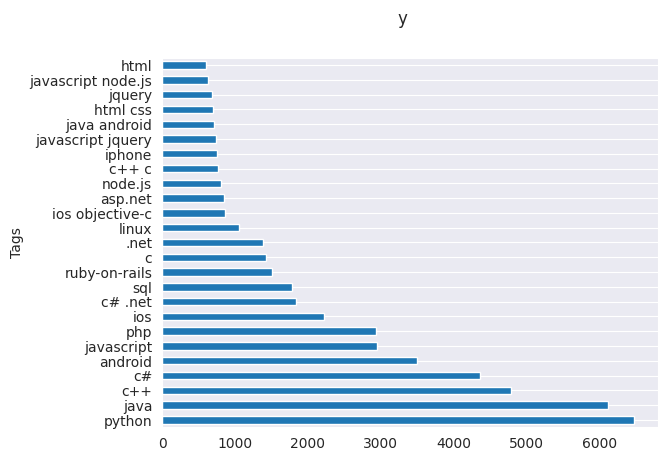

In [19]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
data["Tags"].reset_index().groupby("Tags").count().sort_values(by="index", ascending=False).head(25).plot(kind="barh", legend=False,
                                                                                                        ax=ax).grid(axis='x')
plt.show()

In [21]:
data.shape

(59247, 10)

# Different algorithm used for training

In [21]:
algos = [LogisticRegression(n_jobs=-1, random_state=RANDOM_SEED, max_iter=400),
         CalibratedClassifierCV(LinearSVC(random_state=RANDOM_SEED, max_iter=10_000)), # Must use CalibratedClassifierCV to get probability output
         SGDClassifier(n_jobs=-1, loss="modified_huber", random_state=RANDOM_SEED),
         SGDClassifier(n_jobs=-1, loss="log_loss", random_state=RANDOM_SEED),
         XGBClassifier(random_state=RANDOM_SEED, tree_method='gpu_hist')]

In [22]:
mlb = MultiLabelBinarizer()
X = data["Title"]
y = mlb.fit_transform(data["Tags"].apply(lambda x: x.split(" ")))
print(X.shape, y.shape)

(59247,) (59247, 20)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=data['Tags'])
print(f"Train size : {X_train.shape, y_train.shape}, test size : {X_test.shape, y_test.shape}")

Train size : ((47397,), (47397, 20)), test size : ((11850,), (11850, 20))


# Bag of words
** First test will be to fit and title and transform title + body
** Test result with and without predict_proba

## Only title

### CountVectorizer on title

In [24]:
cv_vector = CountVectorizer(ngram_range=(1, 1))
cv_vector.fit(X_train)
train_feature = cv_vector.transform(X_train + " " + data.loc[X_train.index]['Body'])
test_feature = cv_vector.transform(X_test + " " + data.loc[X_test.index]['Body'])
print(train_feature.shape, test_feature.shape)

(47397, 20516) (11850, 20516)


In [25]:
exp_title = "Sac de mots simple, CountVectorizer : title"

print(exp_title)
for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, False)
    result.append(score)
tab_idx = len(tabel.rows)
print(tabel[:tab_idx].get_string(sortby=metric_name, reversesort=True))

Sac de mots simple, CountVectorizer : title


 20%|██        | 1/5 [00:28<01:52, 28.10s/it]/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

+--------------------------------+-----------+--------+---------------+----------+----------+---------------------------------------------+
|             Model              | Precision | Recall | Jaccard_score | f1_score | Accuracy |               Experiment title              |
+--------------------------------+-----------+--------+---------------+----------+----------+---------------------------------------------+
|         XGBClassifier          |    0.84   |  0.63  |      0.56     |   0.72   |   0.53   | Sac de mots simple, CountVectorizer : title |
|       LogisticRegression       |    0.77   |  0.64  |      0.54     |   0.7    |   0.5    | Sac de mots simple, CountVectorizer : title |
|    SGDClassifier (log_loss)    |    0.79   |  0.61  |      0.53     |   0.69   |   0.49   | Sac de mots simple, CountVectorizer : title |
| SGDClassifier (modified_huber) |    0.62   |  0.62  |      0.45     |   0.62   |   0.39   | Sac de mots simple, CountVectorizer : title |
|           LinearSV

In [26]:
exp_title = "Sac de mots simple, CountVectorizer : title"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Sac de mots simple, CountVectorizer : title


 20%|██        | 1/5 [00:39<02:36, 39.03s/it]/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

+--------------------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------------------+
|             Model              | Precision | Recall | Jaccard_score | f1_score | Accuracy |                      Experiment title                     |
+--------------------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------------------+
|         XGBClassifier          |    0.77   |  0.72  |      0.59     |   0.75   |   0.61   | Sac de mots simple, CountVectorizer : title (seuil : 0.5) |
|    SGDClassifier (log_loss)    |    0.74   |  0.71  |      0.56     |   0.72   |   0.57   | Sac de mots simple, CountVectorizer : title (seuil : 0.5) |
|       LogisticRegression       |    0.72   |  0.71  |      0.56     |   0.71   |   0.55   | Sac de mots simple, CountVectorizer : title (seuil : 0.5) |
|           LinearSVC            |    0.75   |  0.62  |      0.52     |   0.

** On peut constater qu'en fixant un seuil de proba sur nos sorties, on augmente légèrement nos résultats **

In [27]:
cv_vector = CountVectorizer(ngram_range=(1, 2))
cv_vector.fit(X_train)
train_feature = cv_vector.transform(X_train + " " + data.loc[X_train.index]['Body'])
test_feature = cv_vector.transform(X_test + " " + data.loc[X_test.index]['Body'])
print(train_feature.shape, test_feature.shape)

(47397, 163864) (11850, 163864)


In [28]:
exp_title = "Sac de mots ngram_range=(1, 2), CountVectorizer : title"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Sac de mots ngram_range=(1, 2), CountVectorizer : title


100%|██████████| 5/5 [05:28<00:00, 65.73s/it]

+--------------------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------------------------------+
|             Model              | Precision | Recall | Jaccard_score | f1_score | Accuracy |                            Experiment title                           |
+--------------------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------------------------------+
|         XGBClassifier          |    0.77   |  0.72  |      0.59     |   0.74   |   0.61   | Sac de mots ngram_range=(1, 2), CountVectorizer : title (seuil : 0.5) |
|       LogisticRegression       |    0.75   |  0.71  |      0.58     |   0.73   |   0.58   | Sac de mots ngram_range=(1, 2), CountVectorizer : title (seuil : 0.5) |
|    SGDClassifier (log_loss)    |    0.74   |  0.71  |      0.57     |   0.73   |   0.58   | Sac de mots ngram_range=(1, 2), CountVectorizer : title (seuil : 0.5) |
|   

### TfidfVectorizer on title

In [29]:
tfidf_vector = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vector.fit(X_train)
train_feature = tfidf_vector.transform(X_train + " " + data.loc[X_train.index]['Body'])
test_feature = tfidf_vector.transform(X_test + " " + data.loc[X_test.index]['Body'])
print(train_feature.shape, test_feature.shape)

(47397, 20516) (11850, 20516)


In [30]:
exp_title = "Sac de mots simple, TfidfVectorizer : title"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)

print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Sac de mots simple, TfidfVectorizer : title


100%|██████████| 5/5 [00:44<00:00,  8.98s/it]

+--------------------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------------------+
|             Model              | Precision | Recall | Jaccard_score | f1_score | Accuracy |                      Experiment title                     |
+--------------------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------------------+
| SGDClassifier (modified_huber) |    0.8    |  0.71  |      0.6      |   0.75   |   0.62   | Sac de mots simple, TfidfVectorizer : title (seuil : 0.5) |
|           LinearSVC            |    0.79   |  0.72  |      0.6      |   0.75   |   0.62   | Sac de mots simple, TfidfVectorizer : title (seuil : 0.5) |
|       LogisticRegression       |    0.78   |  0.69  |      0.58     |   0.73   |   0.6    | Sac de mots simple, TfidfVectorizer : title (seuil : 0.5) |
|    SGDClassifier (log_loss)    |    0.75   |  0.62  |      0.51     |   0.

In [31]:
tfidf_vector = TfidfVectorizer(ngram_range=(1, 2))
tfidf_vector.fit(X_train)
train_feature = tfidf_vector.transform(X_train + " " + data.loc[X_train.index]['Body'])
test_feature = tfidf_vector.transform(X_test + " " + data.loc[X_test.index]['Body'])
print(train_feature.shape, test_feature.shape)

(47397, 163864) (11850, 163864)


In [32]:
exp_title = "Sac de mots ngram_range=(1, 2), TfidfVectorizer : title"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Sac de mots ngram_range=(1, 2), TfidfVectorizer : title


100%|██████████| 5/5 [01:34<00:00, 18.88s/it]

+--------------------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------------------------------+
|             Model              | Precision | Recall | Jaccard_score | f1_score | Accuracy |                            Experiment title                           |
+--------------------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------------------------------+
|           LinearSVC            |    0.78   |  0.73  |      0.61     |   0.75   |   0.61   | Sac de mots ngram_range=(1, 2), TfidfVectorizer : title (seuil : 0.5) |
| SGDClassifier (modified_huber) |    0.8    |  0.71  |      0.6      |   0.75   |   0.63   | Sac de mots ngram_range=(1, 2), TfidfVectorizer : title (seuil : 0.5) |
|       LogisticRegression       |    0.78   |  0.68  |      0.57     |   0.73   |   0.6    | Sac de mots ngram_range=(1, 2), TfidfVectorizer : title (seuil : 0.5) |
|   

In [33]:
# let's check the quality of the predictions
best_model(train_feature, y_test, mlb, algos[2])

Probability output : [0.         0.8165941  0.         0.         0.         0.
 0.         0.         0.22107399 0.09238574 0.1795194  0.
 0.         0.         0.04012494 0.26463681 0.         0.
 0.         0.        ]
----------------------------------------------------------------------------------------------------
               precision    recall  f1-score   support

         .net       0.65      0.30      0.41       723
      android       0.93      0.89      0.91       920
      asp.net       0.81      0.56      0.66       365
            c       0.65      0.53      0.58       539
           c#       0.70      0.73      0.72      1456
          c++       0.77      0.76      0.76      1220
          css       0.84      0.71      0.77       429
         html       0.67      0.52      0.59       614
          ios       0.80      0.81      0.81       981
       iphone       0.71      0.44      0.54       546
         java       0.87      0.83      0.85      1457
   javascript   

## Title + body

### CountVectorizer title + body

In [34]:
mlb = MultiLabelBinarizer()
X = data["Title"] + " " + data["Body"]
y = mlb.fit_transform(data["Tags"].apply(lambda x: x.split(" ")))
print(X.shape, y.shape)

(59247,) (59247, 20)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED,
                                                    stratify=data['Tags'])
print(f"Train size : {X_train.shape, y_train.shape}, test size : {X_test.shape, y_test.shape}")

Train size : ((47397,), (47397, 20)), test size : ((11850,), (11850, 20))


In [36]:
cv_vector = CountVectorizer(ngram_range=(1, 1))
cv_vector.fit(X_train)
train_feature = cv_vector.transform(X_train)
test_feature = cv_vector.transform(X_test)
print(train_feature.shape, test_feature.shape)

(47397, 217719) (11850, 217719)


In [37]:
exp_title = "Sac de mots simple, CountVectorizer : title + body"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Sac de mots simple, CountVectorizer : title + body


100%|██████████| 5/5 [07:15<00:00, 87.18s/it] 

+--------------------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------------------+
|             Model              | Precision | Recall | Jaccard_score | f1_score | Accuracy |                         Experiment title                         |
+--------------------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------------------+
|         XGBClassifier          |    0.77   |  0.72  |      0.59     |   0.74   |   0.6    | Sac de mots simple, CountVectorizer : title + body (seuil : 0.5) |
|    SGDClassifier (log_loss)    |    0.74   |  0.71  |      0.57     |   0.73   |   0.58   | Sac de mots simple, CountVectorizer : title + body (seuil : 0.5) |
|       LogisticRegression       |    0.74   |  0.72  |      0.57     |   0.73   |   0.57   | Sac de mots simple, CountVectorizer : title + body (seuil : 0.5) |
|           LinearSVC            |

In [38]:
cv_vector = CountVectorizer(ngram_range=(1, 2))
cv_vector.fit(X_train)
train_feature = cv_vector.transform(X_train)
test_feature = cv_vector.transform(X_test)
print(train_feature.shape, test_feature.shape)

(47397, 1799412) (11850, 1799412)


In [39]:
exp_title = "Sac de mots ngram_range=(1, 2), CountVectorizer : title + body"

print(exp_title)

for algo in tqdm(algos[:4]): # skip XGB OOM cuda ! too much dims to compute !!!
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Sac de mots ngram_range=(1, 2), CountVectorizer : title + body


100%|██████████| 4/4 [06:22<00:00, 95.56s/it] 

+--------------------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------------------------------+
|             Model              | Precision | Recall | Jaccard_score | f1_score | Accuracy |                               Experiment title                               |
+--------------------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------------------------------+
|       LogisticRegression       |    0.77   |  0.72  |      0.59     |   0.74   |   0.6    | Sac de mots ngram_range=(1, 2), CountVectorizer : title + body (seuil : 0.5) |
|    SGDClassifier (log_loss)    |    0.76   |  0.72  |      0.58     |   0.74   |   0.59   | Sac de mots ngram_range=(1, 2), CountVectorizer : title + body (seuil : 0.5) |
|           LinearSVC            |    0.78   |  0.69  |      0.58     |   0.73   |   0.6    | Sac de mots ngram_range=(1, 2), CountVect

### TfidfVectorizer title + body

In [40]:
tfidf_vector = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vector.fit(X_train)
train_feature = tfidf_vector.transform(X_train)
test_feature = tfidf_vector.transform(X_test)
print(train_feature.shape, test_feature.shape)

(47397, 217719) (11850, 217719)


In [41]:
exp_title = "Sac de mots simple, TfidfVectorizer : title + body"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Sac de mots simple, TfidfVectorizer : title + body


100%|██████████| 5/5 [01:40<00:00, 20.16s/it]

+--------------------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------------------+
|             Model              | Precision | Recall | Jaccard_score | f1_score | Accuracy |                         Experiment title                         |
+--------------------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------------------+
| SGDClassifier (modified_huber) |    0.8    |  0.72  |      0.61     |   0.76   |   0.63   | Sac de mots simple, TfidfVectorizer : title + body (seuil : 0.5) |
|           LinearSVC            |    0.78   |  0.74  |      0.61     |   0.76   |   0.62   | Sac de mots simple, TfidfVectorizer : title + body (seuil : 0.5) |
|       LogisticRegression       |    0.78   |  0.7   |      0.59     |   0.74   |   0.61   | Sac de mots simple, TfidfVectorizer : title + body (seuil : 0.5) |
|    SGDClassifier (log_loss)    |

In [42]:
tfidf_vector = TfidfVectorizer(ngram_range=(1, 2))
tfidf_vector.fit(X_train)
train_feature = tfidf_vector.transform(X_train)
test_feature = tfidf_vector.transform(X_test)
print(train_feature.shape, test_feature.shape)

(47397, 1799412) (11850, 1799412)


In [43]:
exp_title = "Sac de mots ngram_range=(1, 2), TfidfVectorizer : title + body"

print(exp_title)

for algo in tqdm(algos[:4]): # OOM with XGBClassifier
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Sac de mots ngram_range=(1, 2), TfidfVectorizer : title + body


100%|██████████| 4/4 [03:36<00:00, 54.15s/it] 

+--------------------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------------------------------+
|             Model              | Precision | Recall | Jaccard_score | f1_score | Accuracy |                               Experiment title                               |
+--------------------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------------------------------+
|           LinearSVC            |    0.76   |  0.77  |      0.62     |   0.77   |   0.6    | Sac de mots ngram_range=(1, 2), TfidfVectorizer : title + body (seuil : 0.5) |
| SGDClassifier (modified_huber) |    0.8    |  0.72  |      0.61     |   0.76   |   0.63   | Sac de mots ngram_range=(1, 2), TfidfVectorizer : title + body (seuil : 0.5) |
|       LogisticRegression       |    0.77   |  0.68  |      0.57     |   0.73   |   0.6    | Sac de mots ngram_range=(1, 2), TfidfVect

In [44]:
# let's check the quality of the predictions
best_model(train_feature, y_test, mlb, algos[2])

Probability output : [0.24521998 0.11314294 0.         0.         0.84031866 0.
 0.         0.         0.         0.         0.70488493 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
----------------------------------------------------------------------------------------------------
               precision    recall  f1-score   support

         .net       0.70      0.30      0.42       723
      android       0.93      0.90      0.92       920
      asp.net       0.81      0.57      0.67       365
            c       0.71      0.45      0.55       539
           c#       0.69      0.76      0.72      1456
          c++       0.74      0.79      0.77      1220
          css       0.83      0.74      0.79       429
         html       0.67      0.52      0.59       614
          ios       0.80      0.84      0.82       981
       iphone       0.70      0.42      0.53       546
         java       0.88      0.83      0.85      1457
   javascript   

# Test with TruncatedSVD to reduce the number of dims

In [45]:
n_comp = 500
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), TruncatedSVD(n_components=n_comp))
pipe.fit(X_train)

train_feature = pipe.transform(X_train)
test_feature = pipe.transform(X_test)
print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

Train size : (47397, 500), test size : (11850, 500)


In [46]:
exp_title = f"Truncated SVD ({n_comp} dim) : title + body"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Truncated SVD (500 dim) : title + body


100%|██████████| 5/5 [02:22<00:00, 28.45s/it]

+--------------------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------+
|             Model              | Precision | Recall | Jaccard_score | f1_score | Accuracy |                   Experiment title                   |
+--------------------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------+
|           LinearSVC            |    0.74   |  0.72  |      0.57     |   0.73   |   0.57   | Truncated SVD (500 dim) : title + body (seuil : 0.5) |
| SGDClassifier (modified_huber) |    0.75   |  0.67  |      0.54     |   0.71   |   0.57   | Truncated SVD (500 dim) : title + body (seuil : 0.5) |
|       LogisticRegression       |    0.74   |  0.65  |      0.53     |   0.69   |   0.57   | Truncated SVD (500 dim) : title + body (seuil : 0.5) |
|         XGBClassifier          |    0.72   |  0.63  |      0.51     |   0.67   |   0.55   | Truncated SV

In [47]:
n_comp = 1000
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), TruncatedSVD(n_components=n_comp))
pipe.fit(X_train)

train_feature = pipe.transform(X_train)
test_feature = pipe.transform(X_test)
print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

Train size : (47397, 1000), test size : (11850, 1000)


In [48]:
exp_title = f"Truncated SVD ({n_comp} dim) : title + body"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Truncated SVD (1000 dim) : title + body


100%|██████████| 5/5 [04:06<00:00, 49.40s/it]

+--------------------------------+-----------+--------+---------------+----------+----------+-------------------------------------------------------+
|             Model              | Precision | Recall | Jaccard_score | f1_score | Accuracy |                    Experiment title                   |
+--------------------------------+-----------+--------+---------------+----------+----------+-------------------------------------------------------+
|           LinearSVC            |    0.75   |  0.73  |      0.59     |   0.74   |   0.59   | Truncated SVD (1000 dim) : title + body (seuil : 0.5) |
| SGDClassifier (modified_huber) |    0.76   |  0.69  |      0.57     |   0.72   |   0.59   | Truncated SVD (1000 dim) : title + body (seuil : 0.5) |
|       LogisticRegression       |    0.75   |  0.67  |      0.55     |   0.71   |   0.58   | Truncated SVD (1000 dim) : title + body (seuil : 0.5) |
|         XGBClassifier          |    0.72   |  0.63  |      0.51     |   0.67   |   0.54   | Trunca

# Optimizing BOW with gridsearch

In [49]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(algos[2])),
])
parameters = [{
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__max_features': (None, 10000, 50000),
    'tfidf__ngram_range': ((1, 1), (1, 2)),
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2', None),
}]

grid_search = GridSearchCV(pipeline, parameters, scoring="f1_micro", n_jobs=-1, cv=5, refit=True)

In [50]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        OneVsRestClassifier(estimator=SGDClassifier(loss='modified_huber',
                                                                                    n_jobs=-1,
                                                                                    random_state=42)))]),
             n_jobs=-1,
             param_grid=[{'tfidf__max_df': (0.5, 0.75, 1.0),
                          'tfidf__max_features': (None, 10000, 50000),
                          'tfidf__ngram_range': ((1, 1), (1, 2)),
                          'tfidf__norm': ('l1', 'l2', None),
                          'tfidf__use_idf': (True, False)}],
             scoring='f1_micro')

In [51]:
grid_search.best_score_

0.7118959156455338

In [52]:
grid_search.best_params_

{'tfidf__max_df': 0.75,
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': None,
 'tfidf__use_idf': True}

In [54]:
exp_title = "grid_search for BOW"
probs = grid_search.best_estimator_.predict_proba(X_test)
prediction = np.where(probs >= 0.5, 1, 0)
empty_preds = np.where(~prediction.any(axis=1))[0]
prediction[empty_preds, probs[empty_preds].argmax(axis=1)] = 1
precision = round(precision_score(y_test, prediction, average='weighted'), 2)
recall = round(recall_score(y_test, prediction, average='weighted'), 2)
jaccard = round(jaccard_score(y_test, prediction, average='weighted'), 2)
accuracy = round(accuracy_score(y_test, prediction), 2)
f1 = round(f1_score(y_test, prediction, average='weighted'), 2)
print(f"model : grid_search, precision: {precision}, recall: {recall}, jaccard_score : {jaccard}, F1-measure: {f1}, acc : {accuracy}")
result.append(["LinearSVC with gridsearch", precision, recall, jaccard, f1, accuracy, exp_title])

model : grid_search, precision: 0.77, recall: 0.67, jaccard_score : 0.57, F1-measure: 0.71, acc : 0.54


# Doc2vec Gensim

In [55]:
mlb = MultiLabelBinarizer()
X = data["Title"] + " " + data["Body"]
y = mlb.fit_transform(data["Tags"].apply(lambda x: x.split(" ")))
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED,
                                                    stratify=data['Tags'])
print(f"Train size : {X_train.shape, y_train.shape}, test size : {X_test.shape, y_test.shape}")

(59247,) (59247, 20)
Train size : ((47397,), (47397, 20)), test size : ((11850,), (11850, 20))


In [56]:
card_docs = [TaggedDocument(doc.split(' '), [i])
             for i, doc in enumerate(X_train)]

model = Doc2Vec(vector_size=300, window=5, min_count=1, workers=8, epochs=50)

model.build_vocab(card_docs)

model.train(card_docs, total_examples=model.corpus_count
            , epochs=model.epochs)

In [57]:
train_vec = [model.infer_vector((X_train.to_list()[i].split(' ')))
             for i in range(0, len(X_train))]

train_feature = np.array(train_vec)

test_vec = [model.infer_vector((X_test.to_list()[i].split(' ')))
            for i in range(0, len(X_test))]

test_feature = np.array(test_vec)
print(train_feature.shape, test_feature.shape)

(47397, 300) (11850, 300)


In [58]:
exp_title = "doc2vec : title + body clean"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

doc2vec : title + body clean


 20%|██        | 1/5 [00:18<01:14, 18.67s/it]/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

+--------------------------------+-----------+--------+---------------+----------+----------+--------------------------------------------+
|             Model              | Precision | Recall | Jaccard_score | f1_score | Accuracy |              Experiment title              |
+--------------------------------+-----------+--------+---------------+----------+----------+--------------------------------------------+
|           LinearSVC            |    0.49   |  0.77  |      0.43     |   0.6    |   0.34   | doc2vec : title + body clean (seuil : 0.5) |
|       LogisticRegression       |    0.46   |  0.79  |      0.41     |   0.58   |   0.3    | doc2vec : title + body clean (seuil : 0.5) |
|         XGBClassifier          |    0.62   |  0.53  |      0.4      |   0.57   |   0.46   | doc2vec : title + body clean (seuil : 0.5) |
|    SGDClassifier (log_loss)    |    0.44   |  0.78  |      0.39     |   0.56   |   0.28   | doc2vec : title + body clean (seuil : 0.5) |
| SGDClassifier (modified_h

In [59]:
best_model(train_feature, y_test, mlb, algos[1])

/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iteration

Probability output : [4.07774635e-02 7.16848566e-04 5.11826199e-03 7.63440779e-03
 4.66262976e-02 5.12494613e-03 7.49791883e-04 5.44392328e-03
 9.79924148e-01 2.08550073e-01 5.43654156e-03 7.28259494e-02
 4.89363764e-03 1.17970852e-03 4.47257857e-02 3.55361632e-01
 3.49200082e-03 7.47658038e-03 1.64401120e-02 1.20161167e-03]
----------------------------------------------------------------------------------------------------
               precision    recall  f1-score   support

         .net       0.39      0.47      0.43       723
      android       0.56      0.88      0.69       920
      asp.net       0.38      0.58      0.46       365
            c       0.39      0.74      0.51       539
           c#       0.56      0.80      0.66      1456
          c++       0.54      0.87      0.67      1220
          css       0.39      0.76      0.52       429
         html       0.43      0.56      0.49       614
          ios       0.57      0.85      0.68       981
       iphone       0

# More advanced NLP techniques

## USE (universal sentence encoder)

In [60]:
mlb = MultiLabelBinarizer()
X = data["Title_not_clean"] + ". " + data["Body_not_clean"]
y = mlb.fit_transform(data["Tags"].apply(lambda x: x.split(" ")))
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED,
                                                    stratify=data['Tags'])
print(f"Train size : {X_train.shape, y_train.shape}, test size : {X_test.shape, y_test.shape}")

(59247,) (59247, 20)
Train size : ((47397,), (47397, 20)), test size : ((11850,), (11850, 20))


In [61]:
train_feature = []
for r in tqdm(X_train):

    emb = use_embed([r])
    review_emb = tf.reshape(emb, [-1]).numpy()
    train_feature.append(review_emb)

train_feature = np.array(train_feature)
test_feature = []
for r in tqdm(X_test):
    emb = use_embed([r])
    review_emb = tf.reshape(emb, [-1]).numpy()
    test_feature.append(review_emb)

test_feature = np.array(test_feature)
print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

100%|██████████| 11850/11850 [00:10<00:00, 1102.34it/s]

Train size : (47397, 512), test size : (11850, 512)


In [62]:
exp_title = "use : title + body not clean"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

use : title + body not clean


100%|██████████| 5/5 [02:14<00:00, 26.92s/it]

+--------------------------------+-----------+--------+---------------+----------+----------+--------------------------------------------+
|             Model              | Precision | Recall | Jaccard_score | f1_score | Accuracy |              Experiment title              |
+--------------------------------+-----------+--------+---------------+----------+----------+--------------------------------------------+
|           LinearSVC            |    0.8    |  0.76  |      0.64     |   0.78   |   0.64   | use : title + body not clean (seuil : 0.5) |
| SGDClassifier (modified_huber) |    0.8    |  0.75  |      0.63     |   0.77   |   0.64   | use : title + body not clean (seuil : 0.5) |
|       LogisticRegression       |    0.8    |  0.75  |      0.63     |   0.78   |   0.64   | use : title + body not clean (seuil : 0.5) |
|         XGBClassifier          |    0.8    |  0.74  |      0.62     |   0.77   |   0.63   | use : title + body not clean (seuil : 0.5) |
|    SGDClassifier (log_los

Probability output : [7.45222558e-02 4.87472776e-04 3.47246353e-03 7.49806864e-03
 1.33677019e-01 4.14922926e-02 6.60026709e-05 2.01045662e-03
 2.56855237e-04 5.20847529e-04 3.54670271e-02 2.59241069e-02
 4.95558384e-03 4.06579139e-03 1.88130914e-03 7.89342374e-05
 2.11562792e-03 6.70608550e-02 1.96062998e-04 5.24439533e-03]
----------------------------------------------------------------------------------------------------
               precision    recall  f1-score   support

         .net       0.57      0.36      0.44       723
      android       0.91      0.92      0.91       920
      asp.net       0.74      0.56      0.64       365
            c       0.72      0.62      0.67       539
           c#       0.75      0.81      0.78      1456
          c++       0.82      0.84      0.83      1220
          css       0.86      0.75      0.80       429
         html       0.67      0.53      0.59       614
          ios       0.78      0.83      0.81       981
       iphone       0

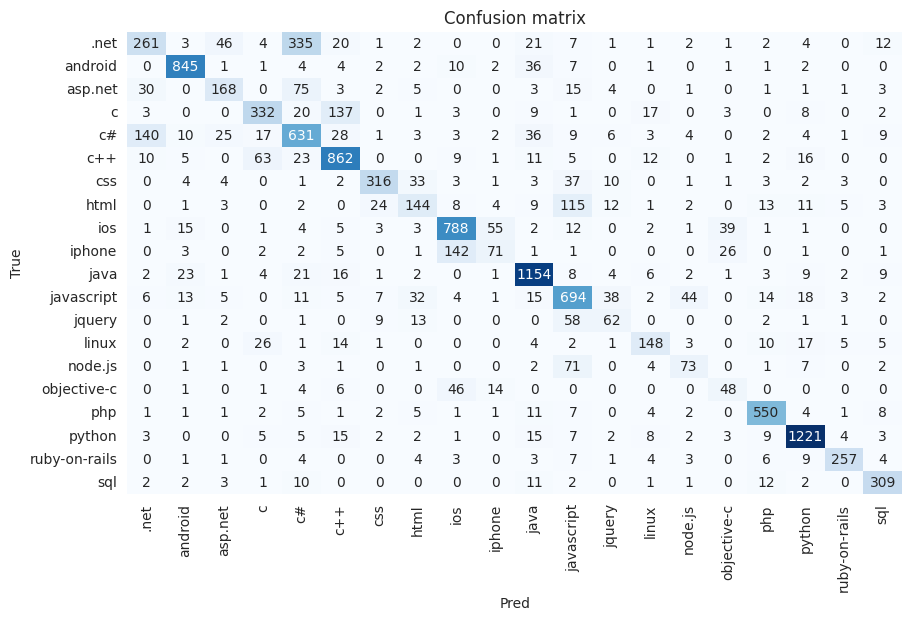

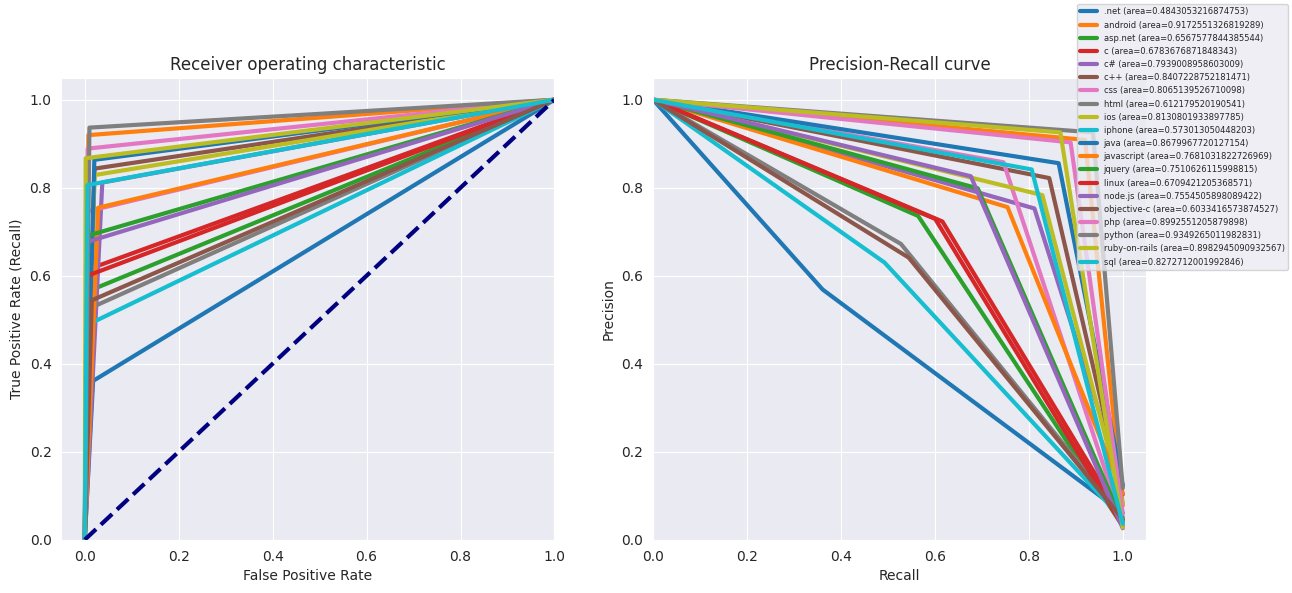

In [63]:
#  let's check the quality of the predictions
best_model(train_feature, y_test, mlb, algos[1], True, True)

## Sentence transformer Bert

In [64]:
mlb = MultiLabelBinarizer()
X = data["Title_not_clean"] + ". " + data["Body_not_clean"]
y = mlb.fit_transform(data["Tags"].apply(lambda x: x.split(" ")))
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED,
                                                    stratify=data['Tags'])
print(f"Train size : {X_train.shape, y_train.shape}, test size : {X_test.shape, y_test.shape}")

(59247,) (59247, 20)
Train size : ((47397,), (47397, 20)), test size : ((11850,), (11850, 20))


### Lightest Bert sentence transformer

In [65]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
train_feature = model.encode(X_train.tolist(), output_value='sentence_embedding', convert_to_numpy=True, normalize_embeddings=False)
test_feature = model.encode(X_test.tolist(), output_value='sentence_embedding', convert_to_numpy=True, normalize_embeddings=False)

print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

Train size : (47397, 384), test size : (11850, 384)


In [66]:
exp_title = "all-MiniLM-L6-v2 : DL not clean"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

all-MiniLM-L6-v2 : DL not clean


100%|██████████| 5/5 [01:54<00:00, 22.97s/it]

+--------------------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------+
|             Model              | Precision | Recall | Jaccard_score | f1_score | Accuracy |                Experiment title               |
+--------------------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------+
|       LogisticRegression       |    0.81   |  0.77  |      0.66     |   0.79   |   0.65   | all-MiniLM-L6-v2 : DL not clean (seuil : 0.5) |
|           LinearSVC            |    0.81   |  0.77  |      0.66     |   0.79   |   0.65   | all-MiniLM-L6-v2 : DL not clean (seuil : 0.5) |
| SGDClassifier (modified_huber) |    0.82   |  0.76  |      0.65     |   0.79   |   0.65   | all-MiniLM-L6-v2 : DL not clean (seuil : 0.5) |
|    SGDClassifier (log_loss)    |    0.82   |  0.75  |      0.64     |   0.78   |   0.65   | all-MiniLM-L6-v2 : DL not clean (seuil : 0.5) |
|     

Probability output : [2.40086748e-02 6.64374118e-04 1.32843576e-03 3.02165032e-03
 1.68926115e-02 1.94109053e-03 1.95520586e-04 2.79728596e-03
 5.90664485e-04 2.51047480e-04 9.78842403e-03 5.13162443e-03
 5.11734706e-04 2.60097349e-02 1.86536822e-03 5.55542838e-04
 1.04137199e-03 9.99611134e-01 4.09157634e-04 1.01270877e-03]
----------------------------------------------------------------------------------------------------
               precision    recall  f1-score   support

         .net       0.56      0.37      0.44       723
      android       0.94      0.92      0.93       920
      asp.net       0.75      0.52      0.61       365
            c       0.76      0.65      0.70       539
           c#       0.75      0.84      0.79      1456
          c++       0.84      0.87      0.86      1220
          css       0.83      0.77      0.80       429
         html       0.68      0.54      0.60       614
          ios       0.78      0.85      0.81       981
       iphone       0

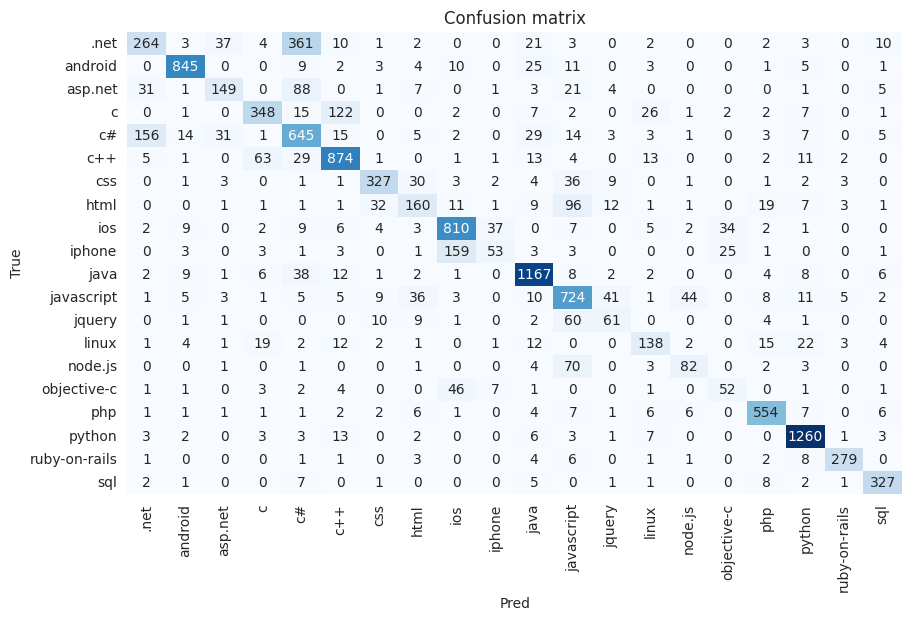

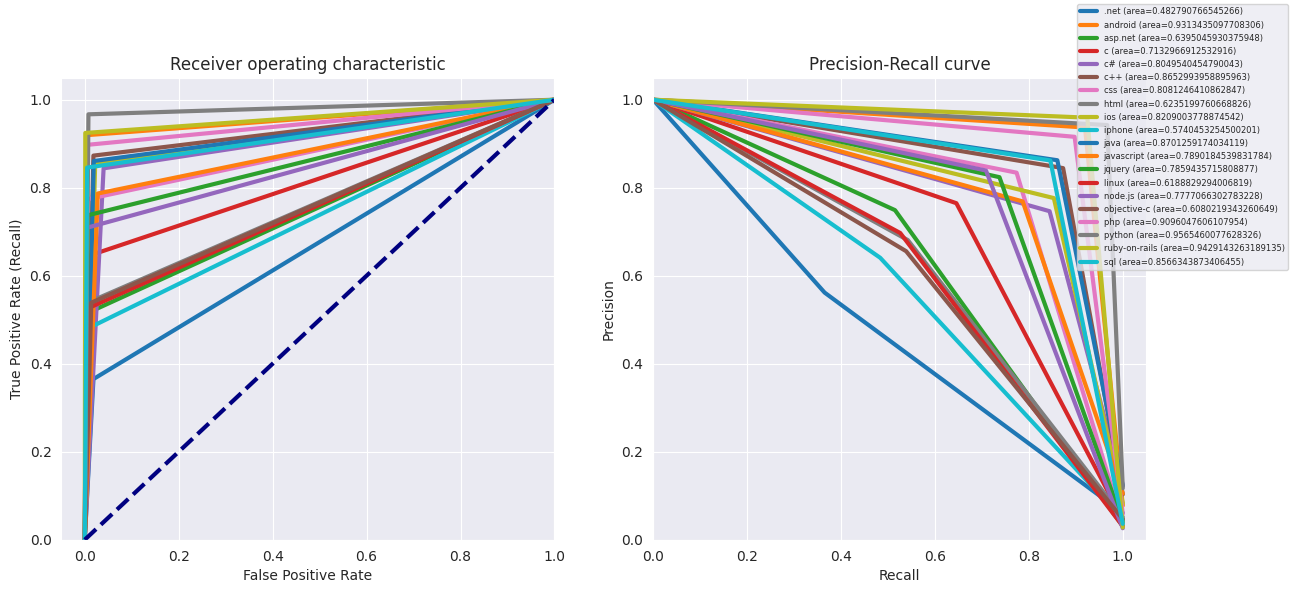

In [67]:
best_model(train_feature, y_test, mlb, algos[0], True, True)

### Heavy sentence transformer model

In [68]:
model = SentenceTransformer('all-mpnet-base-v2')
train_feature = model.encode(X_train.tolist(), output_value='sentence_embedding', convert_to_numpy=True, normalize_embeddings=False)
test_feature = model.encode(X_test.tolist(), output_value='sentence_embedding', convert_to_numpy=True, normalize_embeddings=False)

print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

Train size : (47397, 768), test size : (11850, 768)


In [69]:

exp_title = "all-mpnet-base-v2 : DL not clean"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

all-mpnet-base-v2 : DL not clean


100%|██████████| 5/5 [02:56<00:00, 35.31s/it]

+--------------------------------+-----------+--------+---------------+----------+----------+------------------------------------------------+
|             Model              | Precision | Recall | Jaccard_score | f1_score | Accuracy |                Experiment title                |
+--------------------------------+-----------+--------+---------------+----------+----------+------------------------------------------------+
| SGDClassifier (modified_huber) |    0.84   |  0.78  |      0.68     |   0.81   |   0.68   | all-mpnet-base-v2 : DL not clean (seuil : 0.5) |
|       LogisticRegression       |    0.83   |  0.79  |      0.68     |   0.81   |   0.67   | all-mpnet-base-v2 : DL not clean (seuil : 0.5) |
|           LinearSVC            |    0.83   |  0.79  |      0.68     |   0.81   |   0.68   | all-mpnet-base-v2 : DL not clean (seuil : 0.5) |
|    SGDClassifier (log_loss)    |    0.83   |  0.77  |      0.66     |   0.8    |   0.66   | all-mpnet-base-v2 : DL not clean (seuil : 0.5) |

Probability output : [0.         0.         0.         0.         0.00538979 0.17242289
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.88360807 0.
 0.         0.        ]
----------------------------------------------------------------------------------------------------
               precision    recall  f1-score   support

         .net       0.62      0.30      0.40       723
      android       0.95      0.92      0.94       920
      asp.net       0.73      0.62      0.67       365
            c       0.81      0.65      0.72       539
           c#       0.77      0.89      0.82      1456
          c++       0.87      0.90      0.88      1220
          css       0.85      0.82      0.84       429
         html       0.68      0.58      0.63       614
          ios       0.84      0.72      0.78       981
       iphone       0.62      0.64      0.63       546
         java       0.88      0.89      0.88      1457
   javas

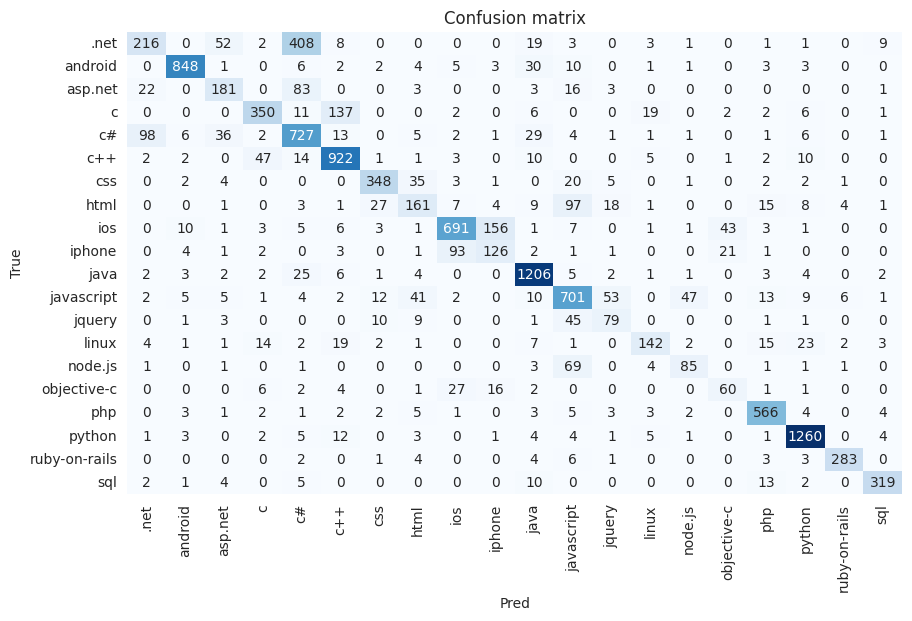

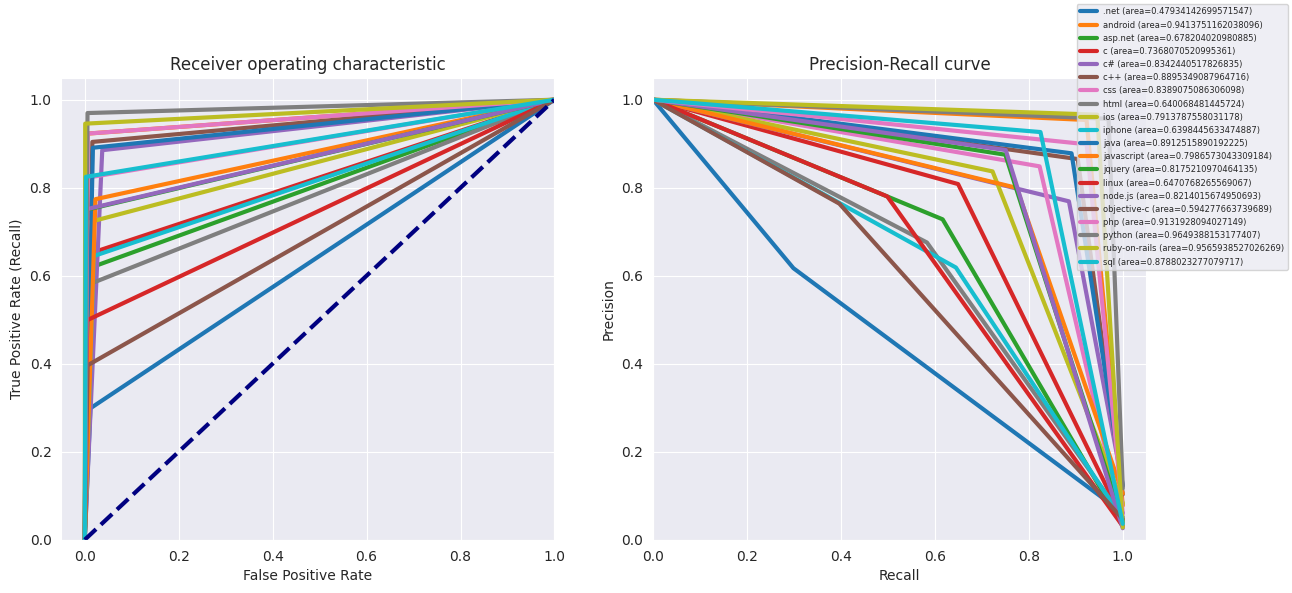

In [70]:
best_model(train_feature, y_test, mlb, algos[2], True, True)

# Train a bert model for sequence classification

In [37]:
torch.cuda.empty_cache()

In [20]:
mlb = MultiLabelBinarizer()
X = pd.DataFrame(data["Title_not_clean"] + ". " + data["Body_not_clean"], columns=["DL_not_clean"])
y = mlb.fit_transform(data["Tags"].apply(lambda x: x.split(" ")))
print(X.shape, y.shape)

(59247, 1) (59247, 20)


### Transforming the dataset into transformers object Dataset

In [21]:
temp_y = pd.DataFrame(y, columns=mlb.classes_.tolist())
transform_df = pd.concat([X, temp_y], axis=1)
transform_df.reset_index(inplace=True, drop=True)
train, test = train_test_split(transform_df, test_size=0.2, random_state=RANDOM_SEED, stratify=data['Tags'])

In [22]:
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)
# Removing index from pandas df
train_dataset = train_dataset.remove_columns(["__index_level_0__"])
test_dataset = test_dataset.remove_columns(["__index_level_0__"])

In [23]:
# format the labels
labels = [label for label in train_dataset.features.keys() if label not in ['DL_not_clean']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

## Test with finetuned on stackoverflow NER model

In [24]:
model_id = "mrm8488/codebert-base-finetuned-stackoverflow-ner" #distilbert-base-uncased
train_batch_size = 8
val_batch_size = 6
metric_name = "f1"
num_epoch = 8

In [25]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [26]:
def preprocess_data(examples):
    # take a batch of texts
    text = examples["DL_not_clean"]
    # encode them
    encoding = tokenizer(text, padding=True, truncation=True, max_length=372)
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    # fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]
    # To match what the model input accepts
    encoding["labels"] = labels_matrix.tolist()

    return encoding

In [27]:
encoded_dataset_train = train_dataset.map(preprocess_data, batched=True, remove_columns=[col for col in train_dataset.features.keys()])
encoded_dataset_test = test_dataset.map(preprocess_data, batched=True, remove_columns=[col for col in test_dataset.features.keys()])
encoded_dataset_train.set_format("torch")
encoded_dataset_test.set_format("torch")

Map:   0%|          | 0/47397 [00:00<?, ? examples/s]

Map:   0%|          | 0/11850 [00:00<?, ? examples/s]

In [28]:
example = encoded_dataset_train[np.random.randint(0, len(train_dataset))]
print(example.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [29]:
# decoded example
tokenizer.decode(example['input_ids'])

"<s>How does UIView nextResponder know what the UIViewController is?. Just as a matter of curiosity, how does the nextResponder method implementation of the UIView class know who is the UIViewController that manages the view? The UIResponder documentation states this, and I can see it work, but I don't quite understand it. To the best of my knowledge, a UIView does not maintain a reference to it's controller, so what's happening behind the scenes? Or am I just missing something obvious? I'm still very new to Objective-C and iPhone development so I apologize if this is something obvious, but I am quite curious. Thanks! </s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [30]:
model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of the model checkpoint at mrm8488/codebert-base-finetuned-stackoverflow-ner were not used when initializing RobertaForSequenceClassification: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at mrm8488/codebert-base-finetuned-stackoverflow-ner and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probab

In [31]:
args = TrainingArguments(
    f"bert-finetuned-classif-stack-overflow",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=val_batch_size,
    num_train_epochs=num_epoch,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

In [32]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset_train,
    eval_dataset=encoded_dataset_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [33]:
trainer.train()

/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 47397
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47400
  Number of trainable parameters = 124661012
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


***** Running Evaluation *****
  Num examples = 11850
  Batch size = 6
Saving model checkpoint to bert-finetuned-classif-stack-overflow/checkpoint-5925
Configuration saved in bert-finetuned-classif-stack-overflow/checkpoint-5925/config.json
Model weights saved in bert-finetuned-classif-stack-overflow/checkpoint-5925/pytorch_model.bin
tokenizer config file saved in bert-finetuned-classif-stack-overflow/checkpoint-5925/tokenizer_config.json
Special tokens file saved in bert-finetuned-classif-stack-overflow/checkpoint-5925/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 11850
  Batch size = 6
Saving model checkpoint to bert-finetuned-classif-stack-overflow/checkpoint-11850
Configuration saved in bert-finetuned-classif-stack-overflow/checkpoint-11850/config.json
Model weights saved in bert-finetuned-classif-stack-overflow/checkpoint-11850/pytorch_model.bin
tokenizer config file saved in bert-finetuned-classif-stack-overflow/checkpoint-11850/tokenizer_config.json
Spe

TrainOutput(global_step=47400, training_loss=0.038691756182079075, metrics={'train_runtime': 14003.2442, 'train_samples_per_second': 27.078, 'train_steps_per_second': 3.385, 'total_flos': 7.24975114138007e+16, 'train_loss': 0.038691756182079075, 'epoch': 8.0})

In [34]:
res = trainer.evaluate()

***** Running Evaluation *****
  Num examples = 11850
  Batch size = 6


In [35]:
torch.cuda.empty_cache()

In [36]:
result.append([model_id, round(res["eval_precision"] ,2), round(res["eval_recall"],2), round(res["eval_jaccard"] ,2), round(res["eval_f1"] ,2), round(res["eval_accuracy"] ,2), "Bert model"])

In [37]:
trainer.save_model("./best_model")
with open('id2label.json', 'w') as fp:
    json.dump(id2label, fp)

Saving model checkpoint to ./best_model
Configuration saved in ./best_model/config.json
Model weights saved in ./best_model/pytorch_model.bin
tokenizer config file saved in ./best_model/tokenizer_config.json
Special tokens file saved in ./best_model/special_tokens_map.json


In [38]:
df_result = pd.DataFrame(result,
                         columns=['Model', 'Precision', 'Recall', 'Jaccard_score', 'f1_score', 'Accuracy', 'Experiment_title'])
df_result.to_csv("res_all_v8_20.csv", index=False)

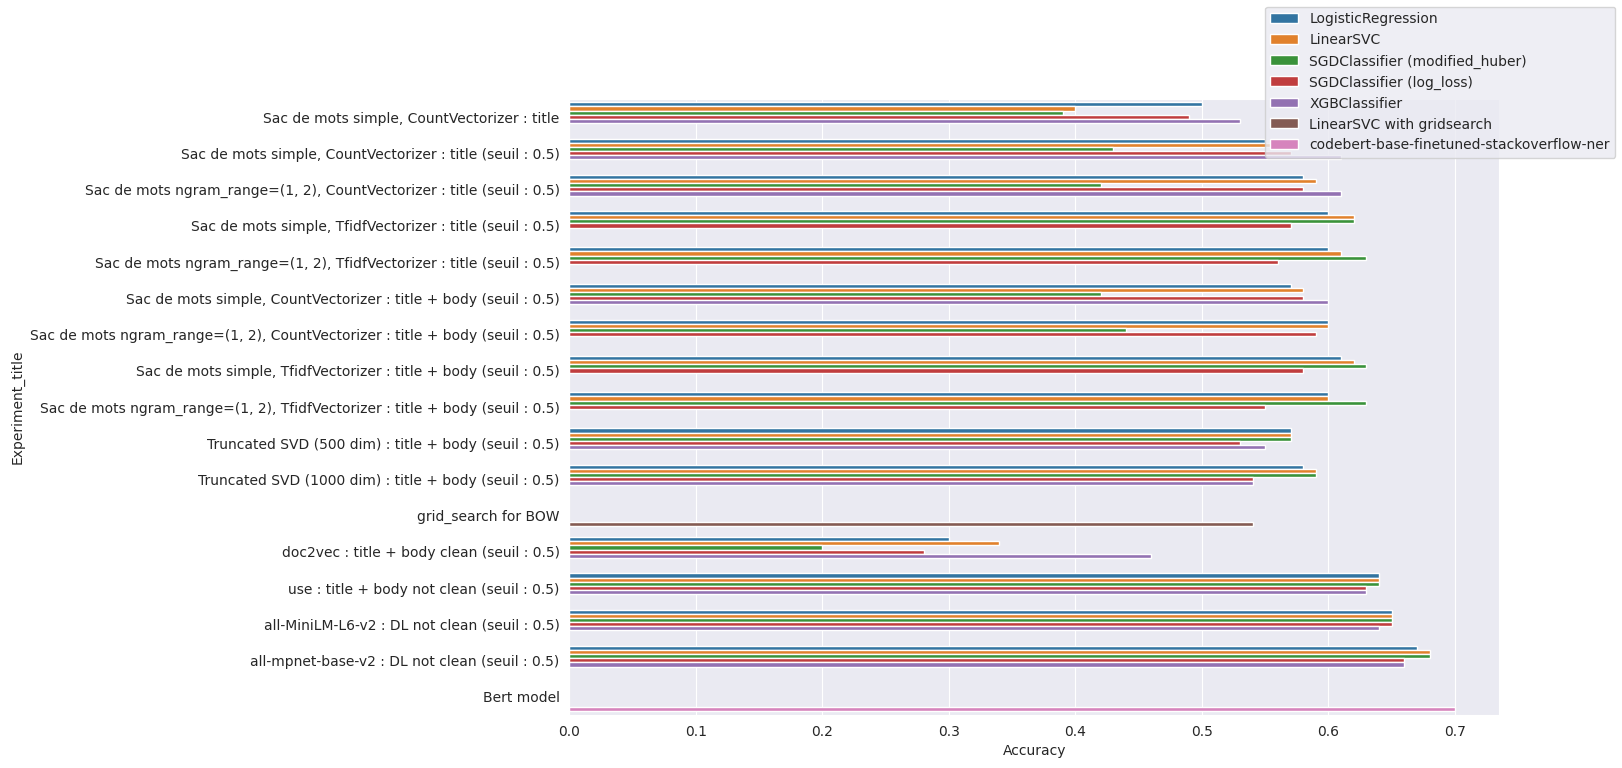

In [58]:
f, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=df_result, x="Accuracy", y="Experiment_title", hue="Model", ax=ax)
ax.legend_.remove()
f.legend()
plt.show()